# GloVe + Logistic Regression / Random Forest Model for Fake News Detection.


In [ ]:

import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk 
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


Make a function to apply text preprocesing to the datasets. Load the data formating it correctly for easy use and apply the preporcessing Split the data into a label and title columns so es easy to access only the title for training

In [2]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra white space
    text = text.strip()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [3]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"../training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"../testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB separator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [4]:
# Apply preprocessing to the 'title' column
train_data['title'] = train_data['title'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)

print(train_data['title'].head())
print(test_data['title'].head())

0    donald trump sends embarrassing new years eve ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas speech
Name: title, dtype: object
0    copycat muslim terrorist arrested assault weapons
1    wow chicago protester caught camera admits vio...
2          germanys fdp look fill schaeubles big shoes
3    mi school sends welcome back packet warning ki...
4    un seeks massive aid boost amid rohingya emerg...
Name: title, dtype: object


Tokenize and lemmatazing

In [5]:
# Tokenize train and testing data
def tokenizeDataframe(text):
    tokens = word_tokenize(text)
    return tokens

train_data['title'] = train_data['title'].apply(tokenizeDataframe)
test_data['title'] = test_data['title'].apply(tokenizeDataframe)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  [donald, trump, sends, embarrassing, new, year...
1      0  [drunk, bragging, trump, staffer, started, rus...
2      0  [sheriff, david, clarke, becomes, internet, jo...
3      0  [trump, obsessed, even, obamas, name, coded, w...
4      0  [pope, francis, called, donald, trump, christm...
  label                                              title
0     2  [copycat, muslim, terrorist, arrested, assault...
1     2  [wow, chicago, protester, caught, camera, admi...
2     2  [germanys, fdp, look, fill, schaeubles, big, s...
3     2  [mi, school, sends, welcome, back, packet, war...
4     2  [un, seeks, massive, aid, boost, amid, rohingy...


In [6]:
#lemmatizer
lemmatizer = WordNetLemmatizer()

#Tag map POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Por defecto

#Lemmatization function
def lemmatize(text):
        pos_tags = pos_tag(text)  
    
        lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
        return lemmatized_words

In [7]:
train_data['title'] = train_data['title'].apply(lemmatize)
test_data['title'] = test_data['title'].apply(lemmatize)


print("examples ready (Train):", train_data['title'].head(5))
print("\nexamples ready (Test):", test_data['title'].head(5))

examples ready (Train): 0    [donald, trump, sends, embarrass, new, year, e...
1    [drunk, brag, trump, staffer, start, russian, ...
2    [sheriff, david, clarke, become, internet, jok...
3    [trump, obsess, even, obamas, name, cod, websi...
4    [pope, francis, call, donald, trump, christmas...
Name: title, dtype: object

examples ready (Test): 0    [copycat, muslim, terrorist, arrest, assault, ...
1    [wow, chicago, protester, catch, camera, admit...
2    [germany, fdp, look, fill, schaeubles, big, shoe]
3    [mi, school, send, welcome, back, packet, warn...
4    [un, seek, massive, aid, boost, amid, rohingya...
Name: title, dtype: object


Load pre-trained GloVe embeddings

In [ ]:
import numpy as np

# Function to load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Call the function properly
glove_embeddings = load_glove_embeddings(r"C:\Users\alvar\Downloads\glove.6B.300d\glove.6B.300d.txt")

embedding_dim = 300


Convert titles to embeddings (average word vectors)

In [9]:
# Function to average word embeddings
def get_average_vector(tokens, embeddings, dim):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    if len(vectors) == 0:
        return np.zeros(dim)  # No known words, return zero vector
    return np.mean(vectors, axis=0)

# Create feature matrices
train_data['vector'] = train_data['title'].apply(lambda x: get_average_vector(x, glove_embeddings, embedding_dim))
test_data['vector'] = test_data['title'].apply(lambda x: get_average_vector(x, glove_embeddings, embedding_dim))

# Convert to matrix
X_train = np.vstack(train_data['vector'].values)
y_train = train_data['label'].values
X_test = np.vstack(test_data['vector'].values)


Train Logistic Regression and RandomForest

In [28]:
# Optional: Split training data to validate model performance
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_tr, y_tr)
y_pred_log = logistic_model.predict(X_val)
# Calculate R²
r2 = r2_score(y_val, y_pred_log)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_tr, y_tr)
y_pred_rf = rf_model.predict(X_val)
# Calculate R²
r2 = r2_score(y_val, y_pred_rf)

# Evaluate models
print("✅ Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_log))
print("\n✅ Logistic Regression Report:\n", classification_report(y_val, y_pred_log))
print(f"R²: {r2}")
print("\n✅ Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("\n✅ Random Forest Report:\n", classification_report(y_val, y_pred_rf))
print(f"R²: {r2}")

✅ Logistic Regression Accuracy: 0.8902064119455424

✅ Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      3515
           1       0.89      0.88      0.89      3316

    accuracy                           0.89      6831
   macro avg       0.89      0.89      0.89      6831
weighted avg       0.89      0.89      0.89      6831

R²: 0.515325753663002

✅ Random Forest Accuracy: 0.878934270238618

✅ Random Forest Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      3515
           1       0.87      0.88      0.88      3316

    accuracy                           0.88      6831
   macro avg       0.88      0.88      0.88      6831
weighted avg       0.88      0.88      0.88      6831

R²: 0.515325753663002


Plotting of confusion matrix

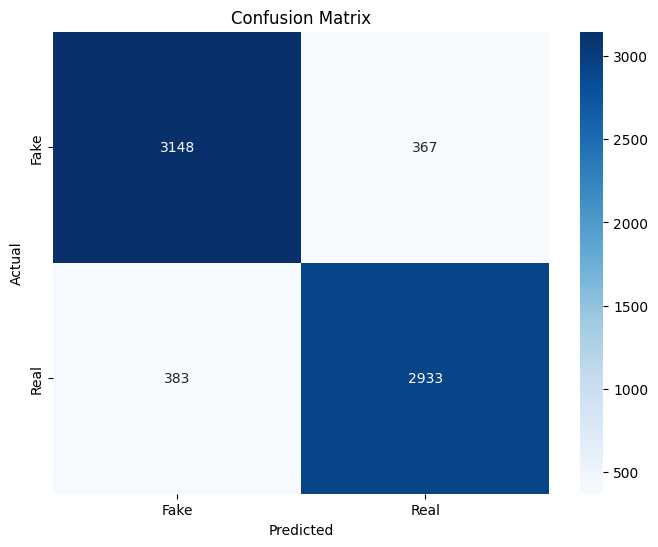

In [ ]:
# Calculate the confusion matrix for Logistic Regression
conf_matrix = confusion_matrix(y_val, y_pred_log)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

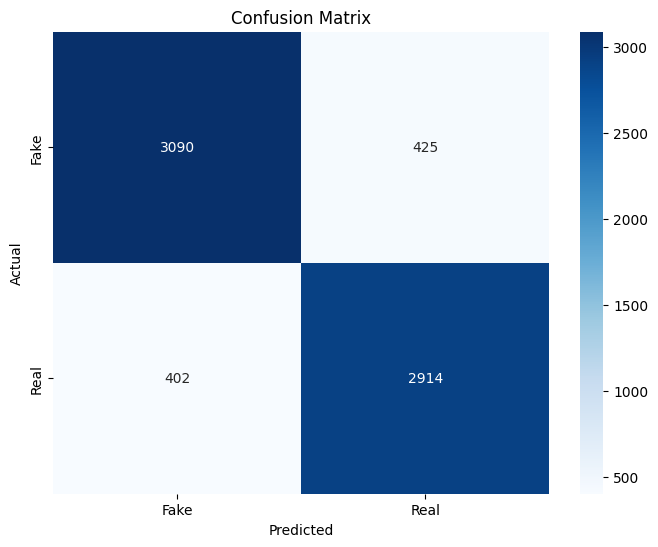

In [26]:
# Calculate the confusion matrix for Random Forest
conf_matrix = confusion_matrix(y_val, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Predict on test data and export CSV

In [32]:
# Make sure title is string, not list
test_data['title'] = test_data['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Export respecting original format
test_data[['label', 'title']].to_csv(
    r'predictions_glove.csv',
    sep='\t',  # TAB separator
    index=False,
    header=False  # No column names
)

print("\n✅ Predictions exported successfully in correct format!")


✅ Predictions exported successfully in correct format!
